# Earth observation project
Привет, дорогой читатель. Вдохновленный первой фотографией черной дыры, я решил написать код на основе NASA API, который будет работать с фотографиями городов и оценивать их озелененность

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import skimage
from skimage import img_as_float
from skimage.io import imread
import pylab
from sklearn.cluster import KMeans
from collections import Counter

In [2]:
# чтобы сделать работу с кодом удобнее, воспользуемся геокодером Яндекс
def find(place):
    url = "https://geocode-maps.yandex.ru/1.x/"
    r = requests.get(url, {'geocode' : place, 'format' : 'json'})
    ll = r.json()['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['Point']['pos'].split()
    return ll

In [3]:
# с Москвой все работает
find('moscow')

['37.617635', '55.755814']

In [4]:
# так как города разного размера, надо решить, какого размера картинку использовать
# мне не удалось найти хороший статистический источник по площади городов, поэтому мы будем исследовать городские центры
# исследуя центры городов, мы сократим время на обработку фотографий
def dim(place):
    return '0.05'

In [5]:
# фотографии города будем запрашивать, использую NASA API
nasa='https://api.nasa.gov/planetary/earth/'
# найдем список изображений для заданной точки
def metadata(place):
        return requests.get(nasa + 'assets?'+ 'lon=' + find(place)[0] + '&lat=' + find(place)[1] + '&api_key=5zvKyrnxuYw6VJxzTia9gfnX8WqFAHVQ5QOxMbT0').json()['results']

In [6]:
# посмотрим на список снимков для Москвы
metadata('Moscow')

[{'date': '2013-04-27T08:30:48', 'id': 'LC8_L1T_TOA/LC81780212013117LGN01'},
 {'date': '2013-05-13T08:30:59', 'id': 'LC8_L1T_TOA/LC81780212013133LGN01'},
 {'date': '2013-06-14T08:31:02', 'id': 'LC8_L1T_TOA/LC81780212013165LGN00'},
 {'date': '2013-06-30T08:31:01', 'id': 'LC8_L1T_TOA/LC81780212013181LGN00'},
 {'date': '2013-07-16T08:31:02', 'id': 'LC8_L1T_TOA/LC81780212013197LGN00'},
 {'date': '2013-08-17T08:31:04', 'id': 'LC8_L1T_TOA/LC81780212013229LGN00'},
 {'date': '2013-09-02T08:31:05', 'id': 'LC8_L1T_TOA/LC81780212013245LGN00'},
 {'date': '2013-09-18T08:31:00', 'id': 'LC8_L1T_TOA/LC81780212013261LGN00'},
 {'date': '2013-10-20T08:30:52', 'id': 'LC8_L1T_TOA/LC81780212013293LGN00'},
 {'date': '2014-01-24T08:30:11', 'id': 'LC8_L1T_TOA/LC81780212014024LGN00'},
 {'date': '2014-02-25T08:29:46', 'id': 'LC8_L1T_TOA/LC81780212014056LGN00'},
 {'date': '2014-03-13T08:29:35', 'id': 'LC8_L1T_TOA/LC81780212014072LGN00'},
 {'date': '2014-03-29T08:29:17', 'id': 'LC8_L1T_TOA/LC81780212014088LGN00'},

In [7]:
# мы собираемся исследовать озелененность городов, поэтому надо выбирать летние снимки (считаем, что все города в северном полушарии)
def summer(meta):
    summer = []
    for i in meta:
        i['date'] = i['date'][0:10]
        if (i['date'][5:7] == '06') or (i['date'][5:7] == '07') or (i['date'][5:7] == '08'):
            summer.append(i['date'])
    return sorted(summer, reverse = True)

In [8]:
# помимо времени года, на некоторых снимках высокая облачность - их тоже надо отсеить
def date(place):
    # проигнорируйте эти 2 строки, в конце узнаете, почему
    if place == 'Saint Petersburg':
        return '2014-08-01'
    s = summer(metadata(place))
    dict = {}
    for date in s:
        cloud = requests.get(nasa + 'imagery/?'+ 'lon=' + find(place)[0] + '&lat=' + find(place)[1] + '&date=' + date + '&cloud_score=True&api_key=5zvKyrnxuYw6VJxzTia9gfnX8WqFAHVQ5QOxMbT0').json()['cloud_score']
        if cloud == 0.0:
            return date
        dict[date] = cloud
    return min(dict, key=dict.get)

In [9]:
# дата самой свежей безоблачной летней фотографии
d = date('moscow')
d

'2014-08-04'

In [10]:
# функция для поиска url картинки
def url_im(place, dim, date):
        return requests.get(nasa + 'imagery/?'+ 'lon=' + find(place)[0] + '&lat=' + find(place)[1] + '&dim=' + dim + '&date=' + date + '&cloud_score=True&api_key=5zvKyrnxuYw6VJxzTia9gfnX8WqFAHVQ5QOxMbT0').json()['url']

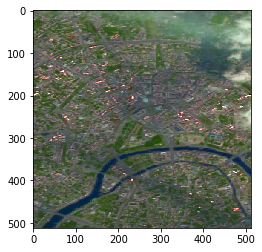

In [11]:
#посмотрим на картинку Москвы
image = img_as_float(imread(url_im('moscow', dim('moscow'), d)))
pylab.imshow(image)

In [12]:
# надо определить зеленость фотографии. Можно это сделать, например, пометив все пиксели, в которых зеленая компонента превышает синюю и красную
def green_coef_1(image):
    df = pd.DataFrame(image.reshape(-1, 3))
    df[3]=np.sign(df[1] - df[0]) + np.sign(df[1] - df[2])
    return df[3].mean()

1.9957389831542969

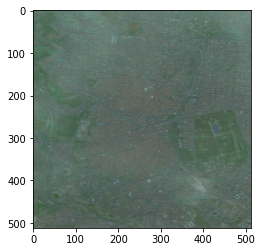

In [13]:
# посмотрим на фотографию Мадрида и посчитаем коэффициент
madrid = img_as_float(imread(url_im('madrid', '0.05', '2014-01-09')))
pylab.imshow(madrid)
green_coef_1(madrid)

Как мы видим, почти все пиксели на фотографии сдвинуты в зеленую сторону. Поскольку снимки делаются в разных условиях, изображение может быть сдвинуто и в другие части спектора. Чтобы решить эту проблему, мы будем использовать модель KMeans, которая будет обучаться на картинке и выделять наиболее "зеленый" кластер.

In [14]:
def green_coef_2(place, img=False):
    
    dm = dim(place)
    dt = date(place)
    
    # скачиваем картинку, которая подходит нам по времени, месту, облачности и размеру
    image = img_as_float(imread(url_im(place, dm, dt)))
    
    # переводим картинку в pd.DataFrame, где столбцы отвечают за RGB
    df = pd.DataFrame(image.reshape(-1, 3))
    
    # найдем самый зеленый кластер и количество элементов в нем. Число кластеров (5) было выбрано эмпирически
    kmeans = KMeans(n_clusters=5, init='k-means++', random_state=241).fit(df)
    def gr(i):
        return 2*i[1]-i[0]-i[2]
    
    idx = np.where(kmeans.cluster_centers_ == max(kmeans.cluster_centers_, key = gr))
    green = Counter(kmeans.labels_)[idx[0][0]]
    all = sum(Counter(kmeans.labels_).values())
    coef = green/all
    
    # если переменная image = True, то рисуем картинку
    if img == True:
        kmeans.cluster_centers_[idx] = [0, 1, 0]
        mean_pixels = [kmeans.cluster_centers_[c] for c in kmeans.labels_]
        mean_image = np.reshape(mean_pixels, (image.shape))
        print(pylab.imshow(mean_image))
        pylab.title(place)
                
    return coef

AxesImage(54,36;334.8x217.44)


0.10999298095703125

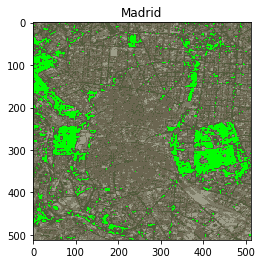

In [15]:
green_coef_2('Madrid', img = True)

Фантастика, код работает! Мы сделали функцию, которая для заданного города определяет долю зеленых насаждений. Посмотрим этот коэффициент для крупнейших городов Европы

In [16]:
url = "https://en.wikipedia.org/wiki/List_of_European_cities_by_population_within_city_limits"
r = requests.get(url)
soup = BeautifulSoup(r.text, 'lxml')

In [17]:
table = soup.find('table',{'class':'wikitable sortable'})
cities = []
for tr in table.find_all('tr'):
    tds = tr.find_all('td')
    if not tds:
        continue
    c = tds[1].find_all('a')
    for i in c:
        if i.get(('title')) != None:
            cities.append(i.get(('title')))

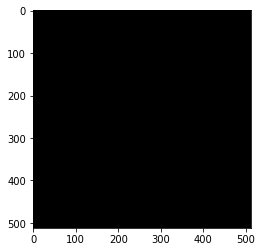

In [18]:
# у Питера большие проблемы с облачностью, а картинка, где облачность 0 - вот такая
image = img_as_float(imread(url_im('Saint Petersburg', dim('Saint Petersburg'), '2014-07-25')))
pylab.imshow(image)

In [19]:
# аккуратно, самая жесткая часть кода (зависнет надолго) - давайте проверять первые 10 городов
green_coef = []
for i in cities[0:10]:
    green_coef.append(green_coef_2(i))

In [20]:
df = pd.DataFrame()
df["City"] = cities[0:10]
df["Green_coef"] = green_coef

In [21]:
df

,City,Green_coef
0,Istanbul,0.071873
1,Moscow,0.171234
2,London,0.170769
3,Saint Petersburg,0.168961
4,Berlin,0.184177
5,Madrid,0.109993
6,Kiev,0.245560
7,Rome,0.146935
8,Paris,0.125484
9,Bucharest,0.143379


AxesImage(54,36;334.8x217.44)


0.2455596923828125

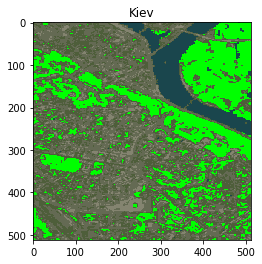

In [24]:
green_coef_2('Kiev', img = True)

Киев - самый зеленый из крупных городов в Европе!
Этот код можно улучшить - я столкнулся с двумя проблемами. Первая - мне не удалось найти хороший статистический источник по площади городов. Поэтому здесь не учтены размеры городов, мы смотрим только на центральную часть (что тоже хорошо и не перегружает компуктер). Второе доступное улучшение - использовать базы данных изображений, выполненных в индексе NDVI (https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index). Этот индекс для растений гораздо контрастнее, чем просто зеленый цвет, поэтому код работал бы лучше. Но я не нашел открытых баз данных по этому индексу, поэтому исспользовал, что есть. Спасибо за внимание!